# Assignment 2 - DES simulation
#### Multiple Queues and Multiple Servers

For this assignment, we'll be using the following notation:
- $\lambda$ - the arrival rate into the system as a whole.
- $\mu$ - the capacity of each of $n$ equal servers.
- $\rho$ represents the system load. In a single server system, it will be: $\rho = \frac{\lambda}{\mu}$
- In a multi-server system (one queue with $n$ equal servers, each with capacity $\mu$), it will be $\rho = \frac{\lambda}{n\mu}$.

Queuing theory tells us that for FIFO scheduling, the average waiting times are shorter for an $M/M/n$ queue and a system load $\rho$ and processor capacity $\mu$ than for a single $M/M/1$ queue with the same load characteristics (and thus an $n$-fold lower arrival rate). Of course, $\rho$ must be less than one, but the experiment only becomes interesting when $\rho$ is not much less than one.

1. Look up and/or derive this theoretical result, at least for $n = 2$. Describe how it is derived. Can you also give a non-mathematical explanation?
2. Write a DES program to verify this for $n = 1, n = 2$, and $n = 4$. Make sure that your result has a high and known statistical significance. How does the number of measurements required to attain this depend on $\rho$?
3. Also compare the result to that for an $M/M/1$ queue with shortest job first scheduling, where you always give priority to the smallest jobs.
4. Now experiment with different service rate distributions. On the one hand, try the $M/D/1$ and $M/D/n$ queues; on the other hand, try a long-tail distribution. For the latter, you may, for example, use a distribution where 75% of the jobs have an exponential distribution with an average service time of 1.0, and the remaining 25% have an exponential distribution with an average service time of 5.0 (an example of a hyperexponential distribution). Write your program using SimPy.



--------
## Q1. Proof
From Little's Law follows: $E(W) = \frac{E(L^q)}{\lambda}$


--------
## Q2. Explanation
Firstly, we have create the framework for a M/M/n queue in the form of a bank with counters and customers. To estimate the true average waiting time $\theta_n$ (depends on n), we proceed to run the simulation for 500 seconds and for $n \in \{1,2,4\}$, for as many repetitions as required to get the average waiting time estimate (mean) within 3 seconds of the true value with 95% confidence. With:

$$ \bar{X}_j = \frac{\sum_{i=1}^{j} X_i}{j} \text{ and } S_j^2 = \frac{\sum_{i=1}^{j} (X_i - \bar{X}_j)^2}{j-1}  $$
 
the sample mean and sample variance of j data values respectively, we keep doing additional simulations (after the first 100) and thus increasing j until the data satisfy $\frac{1.96S}{\sqrt{k}} < 3$. Satisfying this inequality means that the true mean falls within the confidence interval $[\bar{X}_j - 3, \bar{X}_j + 3 ]$ with 95% probability.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import simpy
import itertools
import seaborn as sns
import scipy.stats as stats

from scipy.stats import norm

In [ ]:
class Bank:
    """
    A bank has a limited number of counters (``NUM_COUNTERS``) to serve customers in parallel.
    """

    def __init__(self, env, num_counters, service_rate, priority="FIFO"):
        """
        Initialize the bank with a number of counters (``NUM_COUNTERS``) and a service rate (``MU``).
        priority: FIFO, SJF (shortest job first).

        If shortest job first is used, we require a priorityResource
        """
        self.env = env

        match priority:
            case "FIFO":
                self.counter = simpy.Resource(env, num_counters)
            case "SJF":
                self.counter = simpy.PriorityResource(env, num_counters)
            case _:
                raise ValueError(f"Priority {priority} not supported")

        self.priority = priority
        self.service_rate = service_rate
        self.customers_served = 0
        self.waiting_times = []
        self.service_times = []
    
    def serve(self, customer, waiting_time, service_time):
        """
        The customer is served for a certain amount of time.
        """
        self.customers_served += 1
        self.waiting_times.append(waiting_time)
        self.service_times.append(service_time)
        yield self.env.timeout(service_time)

def setup(env, bank, SIMULATION_TIME, arrival_rate, print_all=False):
    """
    Create new customers until the SIMULATION_TIME reaches a certain value.
    Specify the customer function to use so that different queueing disciplines can be simulated.
    """
    customer_count = itertools.count()

    # Create more cars while the simulation is running
    while env.now < SIMULATION_TIME:
        yield env.timeout(random.expovariate(arrival_rate))
        env.process(customer(env, f'Customer {next(customer_count)}', bank, print_all=print_all))
    

def customer(env, name, bank, print_all=False):
    """
    Customer arrives, is served and leaves.
    priority: FIFO, SJF (shortest job first). 
    """
    arrive = env.now

    # Computer service time here, so it can later be used as priority
    service_time = random.expovariate(bank.service_rate)

    if print_all:
        print(f"{env.now:.4f} {name}: Arrived (my service time is {service_time:.4f})")
        # print('%7.4f %s: Here I am' % (arrive, name))

    # Check what type of  request to make
    match bank.priority:
        case "FIFO":
            request = bank.counter.request()
        case "SJF":
            request = bank.counter.request(priority=service_time)

    with request as req:
        yield req
        wait = env.now - arrive

        if print_all:
            print('%7.4f %s: Waited %6.3f' % (env.now, name, wait))

        yield env.process(bank.serve(name, wait, service_time))

        if print_all:
            print('%7.4f %s: Finished' % (env.now, name))

# Example usage:
RANDOM_SEED = 42
LAMBDA = 1/12 # Arrival rate
MU = 1/10 # Service rate
SIMULATION_TIME = 50
n = 1 # Number of counters

LOAD = LAMBDA/(MU * n) # Load of the system, should be < 1 for stable system

print(f"M/M/1 queue simulation with λ={LAMBDA}, μ={MU}, ρ = {LOAD}")
print(f"Simulation time: {SIMULATION_TIME}")

random.seed(RANDOM_SEED)
env = simpy.Environment()

bank = Bank(env, n, MU)

env.process(setup(env, bank, SIMULATION_TIME, LAMBDA, print_all=True))
env.run()

print(f"Customers served: {bank.customers_served}")
print(f"Average waiting time: {sum(bank.waiting_times)/len(bank.waiting_times)}")


M/M/1 queue simulation with λ=0.08333333333333333, μ=0.1, ρ = 0.8333333333333333
Simulation time: 50
12.2407 Customer 0: Arrived (my service time is 3.2162)
12.2407 Customer 0: Waited  0.000
12.5447 Customer 1: Arrived (my service time is 13.3359)
15.4570 Customer 0: Finished
15.4570 Customer 1: Waited  2.912
15.5757 Customer 2: Arrived (my service time is 22.2729)
28.7929 Customer 1: Finished
28.7929 Customer 2: Waited 13.217
29.1258 Customer 3: Arrived (my service time is 5.4805)
30.2172 Customer 4: Arrived (my service time is 2.4672)
30.5802 Customer 5: Arrived (my service time is 0.2689)
39.0272 Customer 6: Arrived (my service time is 10.4949)
41.6875 Customer 7: Arrived (my service time is 2.4903)
51.0658 Customer 2: Finished
51.0658 Customer 3: Waited 21.940
51.1354 Customer 8: Arrived (my service time is 8.8981)
56.5462 Customer 3: Finished
56.5462 Customer 4: Waited 26.329
59.0134 Customer 4: Finished
59.0134 Customer 5: Waited 28.433
59.2823 Customer 5: Finished
59.2823 Custom

In [ ]:
RANDOM_SEED = 42
SIMULATION_TIME = 500

MU = 1/10 # Service rate
LOAD = 0.99 # Load factor

# We repeat until the average waiting time estimate is within 3 second of the true value (95% confidence)
alpha = 0.05
CI_radius = 3
z = norm.ppf(1-alpha/2) # 1.96 for 95% confidence

decimals = 4 # Number of decimals in results

random.seed(RANDOM_SEED)

for n in [1, 2, 4]:
    avg_customers_served = []
    avg_waiting_times = []
    avg_service_times = []

    while True:
        LAMBDA = MU * LOAD * n

        env = simpy.Environment()
        bank = Bank(env, n, MU)

        env.process(setup(env, bank, SIMULATION_TIME, LAMBDA))
        env.run()

        avg_customers_served.append(bank.customers_served)
        avg_waiting_times.append(sum(bank.waiting_times)/len(bank.waiting_times))
        avg_service_times.append(sum(bank.service_times)/len(bank.service_times))

        # Only start checking after 100 repetitions
        if len(avg_waiting_times) < 100:
            continue

        # Check if the 1-alpha % confidence interval is within CI_radius seconds of the true value
        S = np.std(avg_waiting_times, ddof=1)

        if z * S/np.sqrt(len(avg_waiting_times)) < CI_radius:
            break

    # Print results
    print(f"M/M/{n} queue simulation with λ = {round(LAMBDA, decimals)}, μ = {round(MU, decimals)}, ρ = {round(LOAD, decimals)} ({len(avg_waiting_times)} repetitions to reach 95% confidence)")
    print(f"Customers served: {round(np.mean(avg_customers_served), decimals)}")
    print(f"Average waiting time: {round(np.mean(avg_waiting_times), decimals)} s")
    # print(f"Average service time: {round(np.mean(avg_service_times), decimals)} s\n")

M/M/1 queue simulation with λ = 1.98, μ = 2, ρ = 0.99 (100 repetitions to reach 95% confidence)
Customers served: 986.57
Average waiting time: 10.1775 s
M/M/2 queue simulation with λ = 3.96, μ = 2, ρ = 0.99 (100 repetitions to reach 95% confidence)
Customers served: 1982.3
Average waiting time: 7.1214 s
M/M/4 queue simulation with λ = 7.92, μ = 2, ρ = 0.99 (100 repetitions to reach 95% confidence)
Customers served: 3968.56
Average waiting time: 4.4538 s


### Plotting the box plot when server number = [1,2,4]

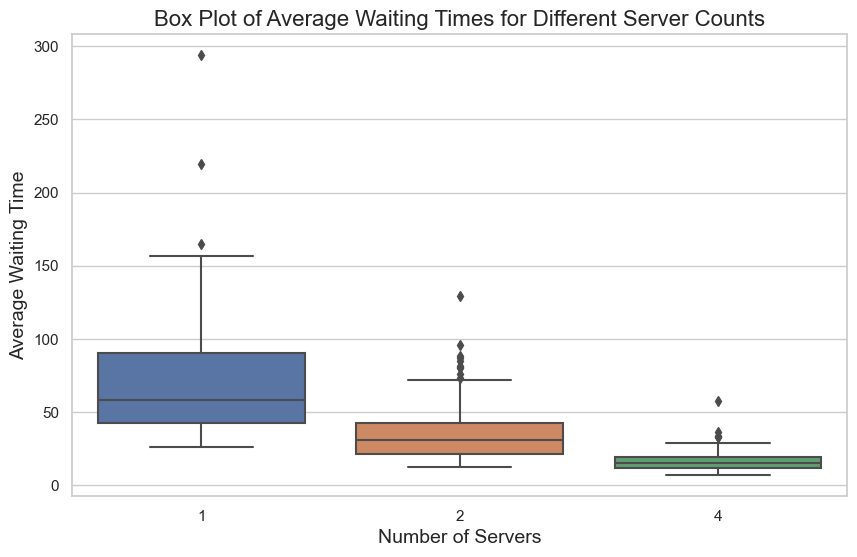

In [ ]:
def run_simulation(num_servers):
    avg_waiting_times = []
    for _ in range(SIMULATIONS):
        env = simpy.Environment()
        bank = Bank(env, num_servers, MU)
        env.process(setup(env, bank, SIMULATION_TIME, num_servers * MU * 0.9))
        env.run()
        avg_waiting_times.append(np.mean(bank.waiting_times))
    return avg_waiting_times

# Parameters for the simulation
MU = 1/10 # Service rate
SIMULATION_TIME = 5000
SIMULATIONS = 100
servers = [1, 2, 4]

# Dictionary to hold simulation results
simulation_results = {}

# Run simulations for different numbers of servers
for num_servers in servers:
    simulation_results[num_servers] = run_simulation(num_servers)

# Preparing data for box plot
data_for_plot = []
for num_servers, times in simulation_results.items():
    for time in times:
        data_for_plot.append([num_servers, time])

# Convert data to DataFrame for plotting
df = pd.DataFrame(data_for_plot, columns=['Servers', 'Mean Waiting Time'])

# Generate box plot
plt.figure(figsize=(10, 6))
sns.set(style='whitegrid')
sns.boxplot(x='Servers', y='Mean Waiting Time', data=df)
plt.title('Box Plot of Average Waiting Times for Different Server Counts', fontsize = 16)
plt.xlabel('Number of Servers', fontsize = 14)
plt.ylabel('Average Waiting Time', fontsize = 14)
plt.show()

### Normal Distribution Test

In [ ]:
def shapiro_wilk_normality_test(data, significance_level=0.05):
    """Perform Shapiro-Wilk normality test on the given data at 95% confidence level."""
    result = stats.shapiro(data)
    print("Shapiro-Wilk test results:")
    print(f"Statistic: {result.statistic}")
    print(f"p-value: {result.pvalue}")
    if result.pvalue > significance_level:
        print("Data appears to be normally distributed at 95% confidence level.")
    else:
        print("Data does not appear to be normally distributed at 95% confidence level.")

for num_servers, times in simulation_results.items():
    print(f"Number of servers: {num_servers}")
    shapiro_wilk_normality_test(times)

Number of servers: 1
Shapiro-Wilk test results:
Statistic: 0.8043590188026428
p-value: 3.377246260427569e-10
Data does not appear to be normally distributed at 95% confidence level.
Number of servers: 2
Shapiro-Wilk test results:
Statistic: 0.8272714614868164
p-value: 1.868722510067755e-09
Data does not appear to be normally distributed at 95% confidence level.
Number of servers: 4
Shapiro-Wilk test results:
Statistic: 0.8408606052398682
p-value: 5.5292956879782196e-09
Data does not appear to be normally distributed at 95% confidence level.


### For different $\rho$:

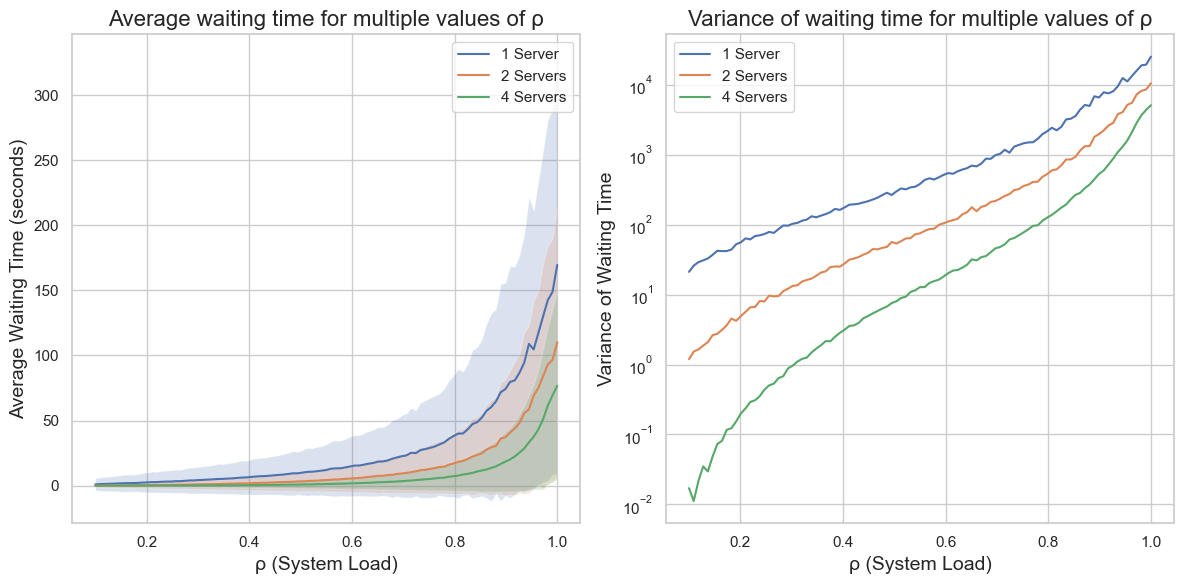

In [ ]:
# Run simulation for different number of servers and system load (rho)
def run_simulation_for_rho(num_counters_list, rho_values, SIMULATION_TIME, service_rate):
    results = {}
    for num_counters in num_counters_list:
        results[num_counters] = {'rho': [], 'avg_waiting_times': [], 'variance_waiting_times': []}
        for rho in rho_values:
            # Lists to accumulate waiting times for each rho value
            waiting_times_accumulator = []
            for _ in range(SIMULATIONS):
                env = simpy.Environment()
                bank = Bank(env, num_counters, service_rate)
                env.process(setup(env, bank, SIMULATION_TIME, rho * service_rate * num_counters))
                env.run()
                waiting_times_accumulator.extend(bank.waiting_times)
            # Calculate average and variance over all simulations for the current rho
            results[num_counters]['rho'].append(rho)
            results[num_counters]['avg_waiting_times'].append(np.mean(waiting_times_accumulator))
            results[num_counters]['variance_waiting_times'].append(np.var(waiting_times_accumulator))
    return results

# Parameters for the simulations
MU = 1/10  # fixed service rate
NUM_COUNTERS_LIST = [1, 2, 4]  # different numbers of servers
SIMULATION_TIME = 5000  # extended simulation time for more data
RHO_VALUES = np.linspace(0.1, 1, 99)  # range of system loads to explore

# Run the simulations
simulation_results = run_simulation_for_rho(NUM_COUNTERS_LIST, RHO_VALUES, SIMULATION_TIME, MU)

# Plotting the results
plt.figure(figsize=(12, 6))

# Plot Average Waiting Time with shaded area for each simulation run
plt.subplot(1, 2, 1)
for num_counters in NUM_COUNTERS_LIST:
    avg_wait = simulation_results[num_counters]['avg_waiting_times']
    plt.plot(RHO_VALUES, avg_wait, label=f'{num_counters} Server{"s" if num_counters > 1 else ""}')
    # Plot the shaded area with variance
    variance_wait = simulation_results[num_counters]['variance_waiting_times']
    plt.fill_between(RHO_VALUES, avg_wait - np.sqrt(variance_wait), avg_wait + np.sqrt(variance_wait), alpha=0.2)

plt.title('Average waiting time for multiple values of ρ', fontsize=16)
plt.xlabel('ρ (System Load)', fontsize=14)
plt.ylabel('Average Waiting Time (seconds)', fontsize=14)
plt.legend()

# Plot Variance as a line plot without shaded area
plt.subplot(1, 2, 2)
for num_counters in NUM_COUNTERS_LIST:
    variance_wait = simulation_results[num_counters]['variance_waiting_times']
    plt.plot(RHO_VALUES, variance_wait, label=f'{num_counters} Server{"s" if num_counters > 1 else ""}')

plt.title('Variance of waiting time for multiple values of ρ', fontsize=16)
plt.xlabel('ρ (System Load)', fontsize=14)
plt.ylabel('Variance of Waiting Time', fontsize=14)
plt.yscale('log')  # Log scale for better visibility
plt.legend()

plt.tight_layout()
plt.show()


#### Confidence interval analysis using CLT

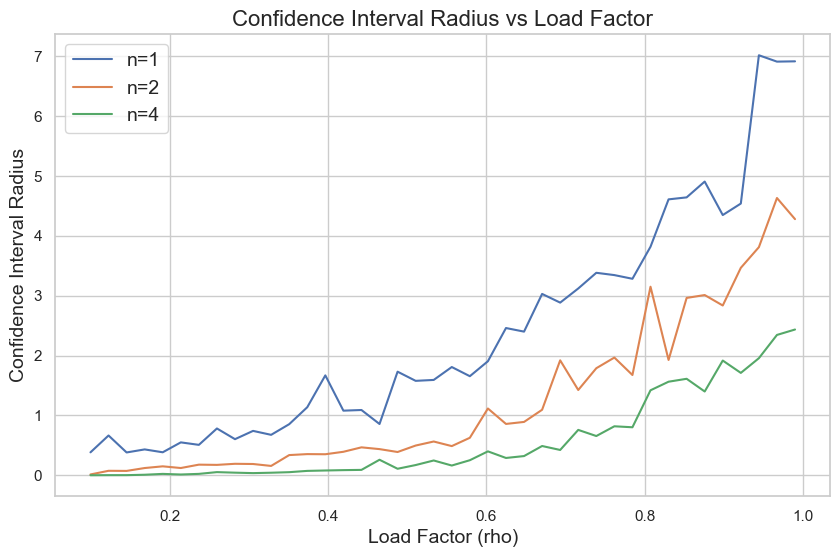

In [ ]:
def simulate_bank(env, num_counters, service_rate, arrival_rate, simulation_time):
    bank = Bank(env, num_counters, service_rate)
    env.process(setup(env, bank, simulation_time, arrival_rate))
    env.run()
    return np.mean(bank.waiting_times)

def calculate_ci(average_times, confidence=0.95):
    n = len(average_times)
    mean = np.mean(average_times)
    sem = np.std(average_times, ddof=1) / np.sqrt(n)
    margin = sem * norm.ppf((1 + confidence) / 2)
    return mean, margin

# Set simulation parameters
RANDOM_SEED = 42
MU = 1/10  # Service rate
SIMULATION_TIME = 500  # Total time for each simulation
NUM_SIMULATIONS = 100  # Number of simulations per load factor
CONFIDENCE = 0.95  # Confidence level for CI
n_values = [1, 2, 4]  # Different numbers of servers to simulate
rho_values = np.linspace(0.1, 0.99, 40)  # Load factors

# Set the random seed for reproducibility
random.seed(RANDOM_SEED)

# Store the results
ci_results = []

# Run the simulations
for n in n_values:
    for rho in rho_values:
        arrival_rate = MU * n * rho
        average_times = []
        for _ in range(NUM_SIMULATIONS):
            env = simpy.Environment()
            avg_time = simulate_bank(env, n, MU, arrival_rate, SIMULATION_TIME)
            average_times.append(avg_time)
        mean, margin = calculate_ci(average_times, CONFIDENCE)
        ci_results.append((n, rho, mean, margin))

# Plotting the results
plt.figure(figsize=(10, 6))

for n in n_values:
    n_results = [(rho, margin) for n_res, rho, mean, margin in ci_results if n_res == n]
    rho_values, margins = zip(*n_results)
    plt.plot(rho_values, margins, label=f'n={n}')

plt.xlabel('Load Factor (rho)', fontsize=14)
plt.ylabel('Confidence Interval Radius', fontsize=14)
plt.title('Confidence Interval Radius vs Load Factor', fontsize=16)
plt.legend(fontsize=14)
plt.grid(True)
plt.show()


#### How many simulations do we need to get CI_radius down to 3

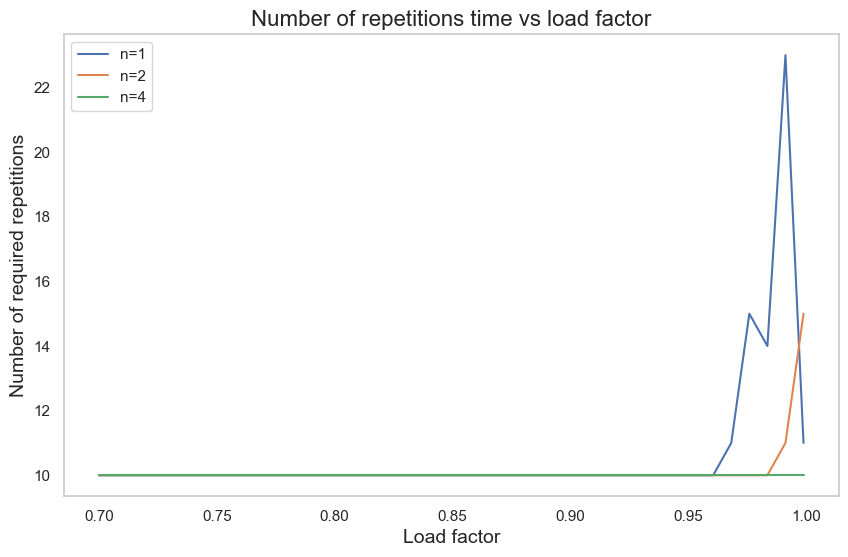

In [ ]:
# Number of measurements vs load factor
RANDOM_SEED = 42
SIMULATION_TIME = 500

MU = 2 # Service rate

# We repeat until the average waiting time estimate is within 3 second of the true value (95% confidence)
alpha = 0.05
CI_radius = 3
z = norm.ppf(1-alpha/2) # 1.96 for 95% confidence

decimals = 4 # Number of decimals in results

random.seed(RANDOM_SEED)

results = pd.DataFrame(columns=['n', 'load', 'avg_customers_served', 'avg_waiting_time', 'repetitions'])

for n in [1, 2, 4]:
    for LOAD in np.linspace(0.7, 0.999, 40):
        avg_customers_served = []
        avg_waiting_times = []
        
        while True:
            LAMBDA = MU * LOAD * n

            env = simpy.Environment()
            bank = Bank(env, n, MU)

            env.process(setup(env, bank, SIMULATION_TIME, LAMBDA))
            env.run()

            avg_customers_served.append(bank.customers_served)
            avg_waiting_times.append(sum(bank.waiting_times)/len(bank.waiting_times))

            # Only start checking after 100 repetitions
            if len(avg_waiting_times) < 10:
                continue

            # Check if the 1-alpha % confidence interval is within CI_radius seconds of the true value
            S = np.std(avg_waiting_times, ddof=1)

            if z * S/np.sqrt(len(avg_waiting_times)) < CI_radius:
                break
        
        results.loc[len(results) - 1] = {
            'n': n,
            'load': LOAD,
            'avg_customers_served': np.mean(avg_customers_served),
            'avg_waiting_time': np.mean(avg_waiting_times),
            'repetitions': len(avg_waiting_times)
        }
        
results_n1 = results[results['n'] == 1]
results_n2 = results[results['n'] == 2]
results_n4 = results[results['n'] == 4]

# Plot results
plt.figure(figsize=(10, 6))
plt.title("Number of repetitions time vs load factor", fontsize = 16)
plt.xlabel("Load factor", fontsize = 14)
plt.ylabel("Number of required repetitions", fontsize = 14)
plt.grid()
plt.plot(results_n1['load'], results_n1['repetitions'], label="n=1")
plt.plot(results_n2['load'], results_n2['repetitions'], label="n=2")
plt.plot(results_n4['load'], results_n4['repetitions'], label="n=4")
plt.legend()
plt.show()


In [ ]:
results

,n,load,avg_customers_served,avg_waiting_time,repetitions
-1,1,0.700000,30.326241,20.239488,141
0,2,0.700000,59.840000,10.498237,100
1,4,0.700000,117.750000,3.689409,100
2,1,0.707667,30.425926,18.929886,108
3,2,0.707667,58.330000,9.131270,100
...,...,...,...,...,...
114,2,0.991333,83.283951,31.798043,243
115,4,0.991333,165.920000,21.414622,100
116,1,0.999000,42.544369,48.800595,586
117,2,0.999000,83.875000,33.521247,296


#### How many simulations do we need to get CI_radius down to 1

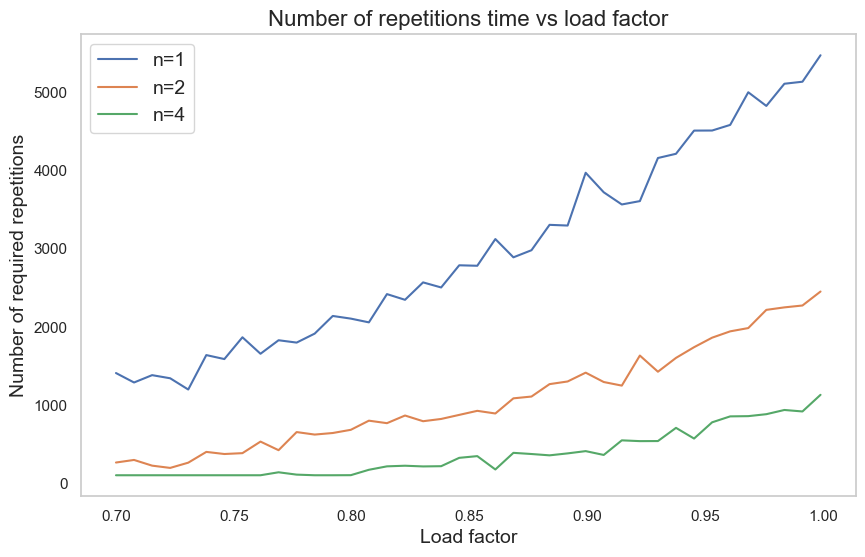

In [ ]:
# Number of measurements vs load factor
RANDOM_SEED = 42
SIMULATION_TIME = 500

MU = 1/12 # Service rate

# We repeat until the average waiting time estimate is within 3 second of the true value (95% confidence)
alpha = 0.05
CI_radius = 1
z = norm.ppf(1-alpha/2) # 1.96 for 95% confidence

decimals = 4 # Number of decimals in results

random.seed(RANDOM_SEED)

results = pd.DataFrame(columns=['n', 'load', 'avg_customers_served', 'avg_waiting_time', 'repetitions'])

for n in [1, 2, 4]:
    for LOAD in np.linspace(0.7, 0.999, 40):
        avg_customers_served = []
        avg_waiting_times = []
        
        while True:
            LAMBDA = MU * LOAD * n

            env = simpy.Environment()
            bank = Bank(env, n, MU)

            env.process(setup(env, bank, SIMULATION_TIME, LAMBDA))
            env.run()

            avg_customers_served.append(bank.customers_served)
            avg_waiting_times.append(sum(bank.waiting_times)/len(bank.waiting_times))

            # Only start checking after 100 repetitions
            if len(avg_waiting_times) < 100:
                continue

            # Check if the 1-alpha % confidence interval is within CI_radius seconds of the true value
            S = np.std(avg_waiting_times, ddof=1)

            if z * S/np.sqrt(len(avg_waiting_times)) < CI_radius:
                break
        
        results.loc[len(results) - 1] = {
            'n': n,
            'load': LOAD,
            'avg_customers_served': np.mean(avg_customers_served),
            'avg_waiting_time': np.mean(avg_waiting_times),
            'repetitions': len(avg_waiting_times)
        }

results_n1 = results[results['n'] == 1]
results_n2 = results[results['n'] == 2]
results_n4 = results[results['n'] == 4]

# Plot results
plt.figure(figsize=(10, 6))
plt.title("Number of repetitions time vs load factor", fontsize=16)
plt.xlabel("Load factor", fontsize=14)
plt.ylabel("Number of required repetitions", fontsize=14)
plt.grid()
plt.plot(results_n1['load'], results_n1['repetitions'], label="n=1")
plt.plot(results_n2['load'], results_n2['repetitions'], label="n=2")
plt.plot(results_n4['load'], results_n4['repetitions'], label="n=4")
plt.legend(fontsize=14)
plt.show()

--------
## Q3. Explanation
For the shortest job first scheduling, we edited the initial class 'Bank' and function 'customer'. The 'Bank' class now has a 'priority' parameter that takes either "FIFO" or "SJF" and changes the counter 'simpy.Resource' to a 'simpy.PriorityResource' if its an SJF. The 'customer' function checks the priority from the bank object, and if this is an "SJF" bank, it creates requests with priority equal to the predetermined service time. Since smaller priority values are put at the front of the line, this means that the shortest job is serviced first.

In the next code block we give an example usage (seed = 42). Customers 3, 4, 5, 6 and 7 all arrive during customer 2's (considerable) service time. After customer 2 is finished, customer 5 is serviced first since they have the lowest service time (0.2689). Customers 4, 7 and 3 follow shortly, also in order of shortest service time.

When comparing the load to the number of repetitions required to reach the 95% significance, we change the confidence interval radius to 1 because the SJF queues turned out to reach the 95% significance within 50 repetitions in a lot of cases.

### Box Plot

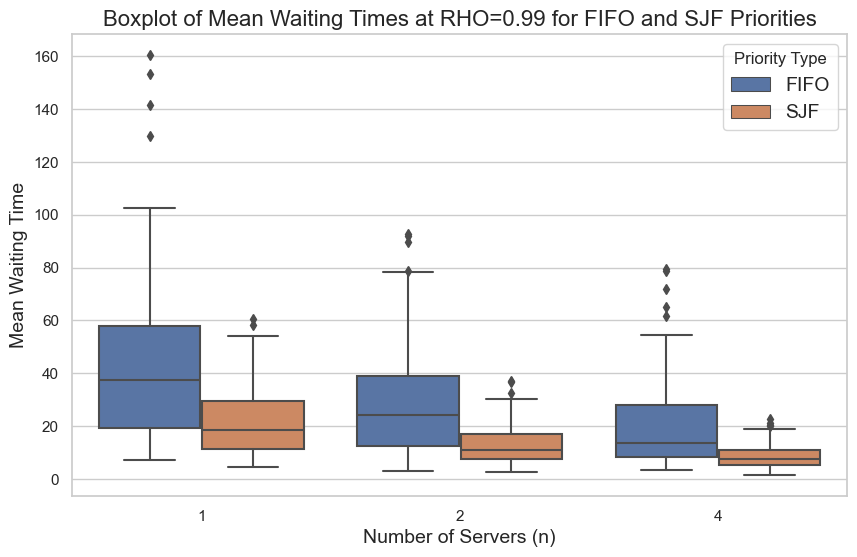

In [ ]:
# Define the simulation function for FIFO and SJF
def simulate(env, num_counters, service_rate, arrival_rate, priority_type, simulation_time):
    bank = Bank(env, num_counters, service_rate, priority_type)
    env.process(setup(env, bank, simulation_time, arrival_rate))
    env.run()
    return np.mean(bank.waiting_times)

# Set the random seed
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

# Simulation parameters
MU = 1/10
SIMULATION_TIME = 500
NUM_SIMULATIONS = 100
CONFIDENCE_LEVEL = 0.95
n_values = [1, 2, 4]
priority_types = ["FIFO", "SJF"]
RHO = 0.99

# Initialize results storage
waiting_times_data = {
    'Priority': [],
    'Servers': [],
    'WaitingTime': []
}

# Perform simulations
# Perform simulations and collect mean waiting times
for priority_type in priority_types:
    for n in n_values:
        # Set the arrival rate based on RHO and number of servers
        arrival_rate = RHO * MU * n
        
        # Run the simulations and collect mean waiting times
        mean_waiting_times = []
        for _ in range(NUM_SIMULATIONS):
            env = simpy.Environment()
            mean_waiting_time = simulate(env, n, MU, arrival_rate, priority_type, SIMULATION_TIME)
            mean_waiting_times.append(mean_waiting_time)
        
        # Store the mean waiting times data
        waiting_times_data['Priority'].extend([priority_type] * NUM_SIMULATIONS)
        waiting_times_data['Servers'].extend([n] * NUM_SIMULATIONS)
        waiting_times_data['WaitingTime'].extend(mean_waiting_times)

# Convert collected data to DataFrame
waiting_times_df = pd.DataFrame(waiting_times_data)

# Plotting the boxplot for mean waiting time at RHO=0.99
plt.figure(figsize=(10, 6))
sns.boxplot(data=waiting_times_df, x='Servers', y='WaitingTime', hue='Priority')
plt.title('Boxplot of Mean Waiting Times at RHO=0.99 for FIFO and SJF Priorities', fontsize=16)
plt.xlabel('Number of Servers (n)', fontsize=14)
plt.ylabel('Mean Waiting Time', fontsize=14)
plt.legend(title='Priority Type', fontsize=14)
plt.show()

### For different $\rho$:
#### Mean waiting time & Variance

In [ ]:
# Define the parameters for the simulation
RANDOM_SEED = 42
MU = 1/10  # Service rate
SIMULATION_TIME = 5000  # Total time for each simulation
NUM_SIMULATIONS = 100  # Number of simulations per load factor
n_values = [1, 2, 4]  # Different numbers of servers to simulate
priority_types = ["FIFO", "SJF"]  # Types of queueing disciplines
rho_values = np.linspace(0.1, 0.99, 99)  # Load factors

# Set the random seed for reproducibility
random.seed(RANDOM_SEED)

# Initialize a dictionary to store the simulation results
waiting_times_results = {
    'Priority': [],
    'Servers': [],
    'Rho': [],
    'Mean Waiting Time': [],
    'Variance Waiting Time': []
}

# Run the simulations across all combinations of priority type, number of servers, and rho values
for priority_type in priority_types:
    for n in n_values:
        for rho in rho_values:
            # Calculate the arrival rate for the given rho and number of servers
            arrival_rate = rho * MU * n
            
            # Initialize a list to store waiting times for each simulation
            simulation_waiting_times = []
            
            # Run the specified number of simulations and collect the waiting times
            for _ in range(NUM_SIMULATIONS):
                env = simpy.Environment()
                # Assuming simulate function returns the mean waiting time for the simulation
                mean_waiting_time = simulate(env, n, MU, arrival_rate, priority_type, SIMULATION_TIME)
                simulation_waiting_times.append(mean_waiting_time)
            
            # Calculate the mean and variance of the collected mean waiting times
            mean_of_means = np.mean(simulation_waiting_times)
            variance_of_means = np.var(simulation_waiting_times)
            
            # Append the results to the waiting_times_results dictionary
            waiting_times_results['Priority'].append(priority_type)
            waiting_times_results['Servers'].append(n)
            waiting_times_results['Rho'].append(rho)
            waiting_times_results['Mean Waiting Time'].append(mean_of_means)
            waiting_times_results['Variance Waiting Time'].append(variance_of_means)


# Convert the results dictionary to a DataFrame for analysis and plotting
df_waiting_times_results = pd.DataFrame(waiting_times_results)




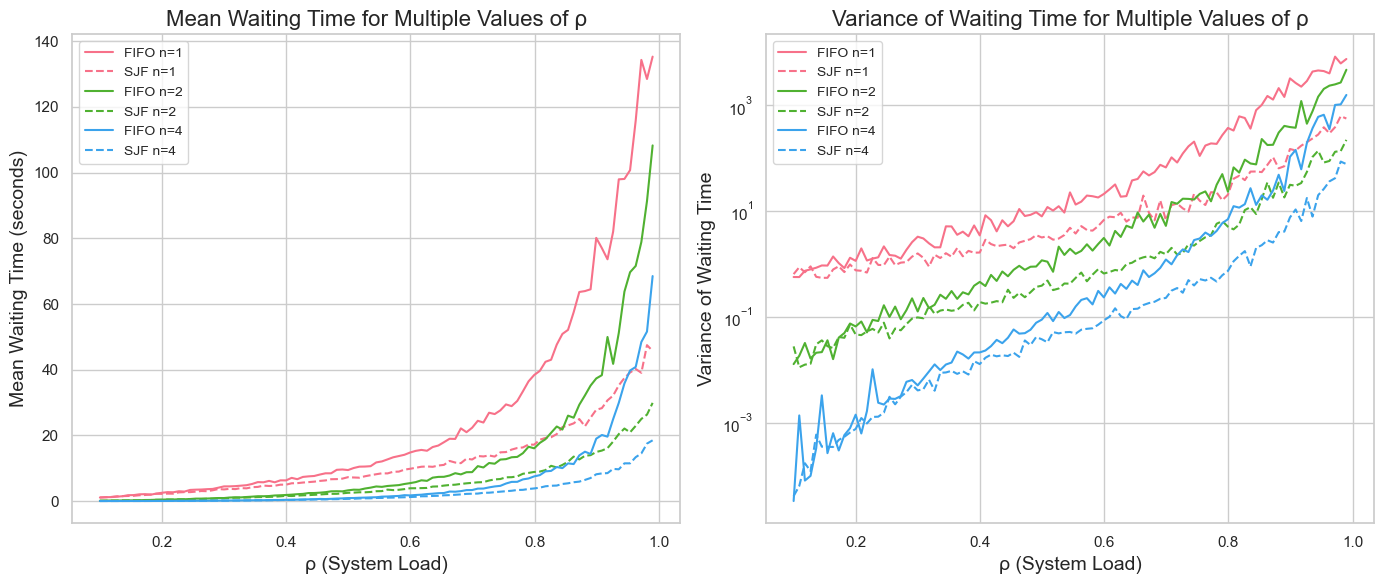

In [ ]:
# Create a 1x2 subplot structure
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Set the font sizes
title_fontsize = 16
label_fontsize = 14
legend_fontsize = 10

# Set color palette for the number of servers
palette = sns.color_palette("husl", n_colors=len(n_values))

# Plot the mean waiting time on the left axis (ax1)
ax1 = axes[0]
for i, n in enumerate(n_values):
    # Filter the dataframe for FIFO and plot
    subset_fifo = df_waiting_times_results[(df_waiting_times_results['Priority'] == 'FIFO') & (df_waiting_times_results['Servers'] == n)]
    ax1.plot(subset_fifo['Rho'], subset_fifo['Mean Waiting Time'], label=f'FIFO n={n}', color=palette[i], linestyle='-')
    
    # Filter the dataframe for SJF and plot
    subset_sjf = df_waiting_times_results[(df_waiting_times_results['Priority'] == 'SJF') & (df_waiting_times_results['Servers'] == n)]
    ax1.plot(subset_sjf['Rho'], subset_sjf['Mean Waiting Time'], label=f'SJF n={n}', color=palette[i], linestyle='--')

ax1.set_title('Mean Waiting Time for Multiple Values of ρ', fontsize=title_fontsize)
ax1.set_xlabel('ρ (System Load)', fontsize=label_fontsize)
ax1.set_ylabel('Mean Waiting Time (seconds)', fontsize=label_fontsize)
ax1.legend(fontsize=legend_fontsize)
ax1.grid(True)

# Plot the variance of waiting time on the right axis (ax2)
ax2 = axes[1]
for i, n in enumerate(n_values):
    # Filter the dataframe for FIFO and plot
    subset_fifo = df_waiting_times_results[(df_waiting_times_results['Priority'] == 'FIFO') & (df_waiting_times_results['Servers'] == n)]
    ax2.plot(subset_fifo['Rho'], subset_fifo['Variance Waiting Time'], label=f'FIFO n={n}', color=palette[i], linestyle='-')
    
    # Filter the dataframe for SJF and plot
    subset_sjf = df_waiting_times_results[(df_waiting_times_results['Priority'] == 'SJF') & (df_waiting_times_results['Servers'] == n)]
    ax2.plot(subset_sjf['Rho'], subset_sjf['Variance Waiting Time'], label=f'SJF n={n}', color=palette[i], linestyle='--')

ax2.set_title('Variance of Waiting Time for Multiple Values of ρ', fontsize=title_fontsize)
ax2.set_xlabel('ρ (System Load)', fontsize=label_fontsize)
ax2.set_ylabel('Variance of Waiting Time', fontsize=label_fontsize)
ax2.set_yscale('log')
ax2.legend(fontsize=legend_fontsize)
ax2.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

#### Confidence Interval Analysis

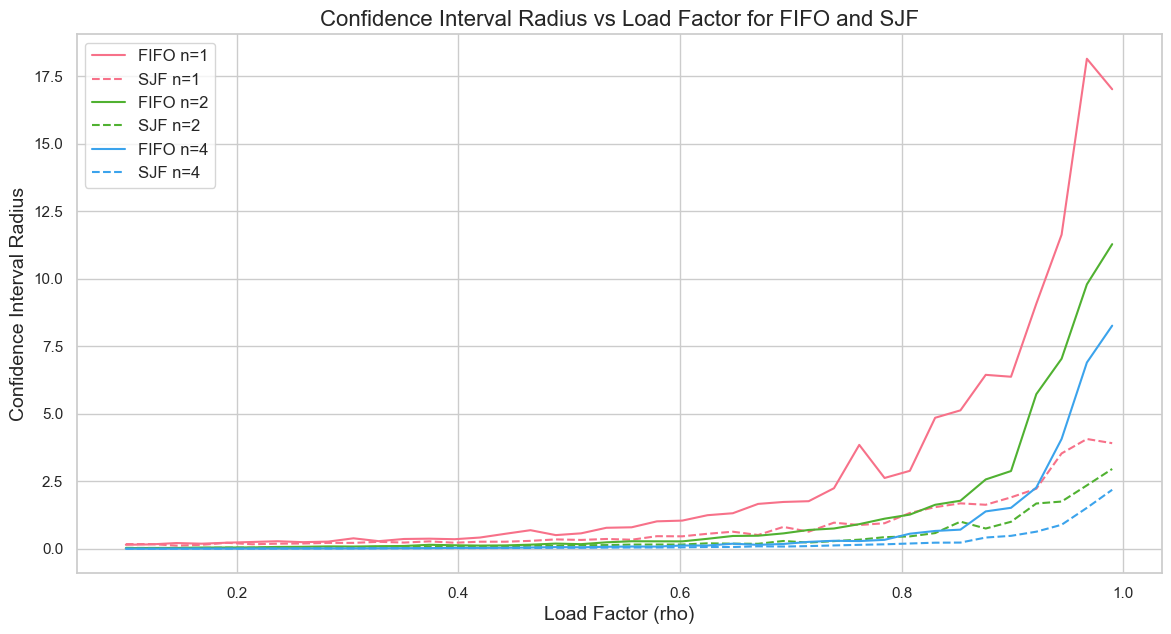

In [ ]:
# Function to calculate the CI
def calculate_ci(average_times, confidence=0.95):
    n = len(average_times)
    mean = np.mean(average_times)
    sem = np.std(average_times, ddof=1) / np.sqrt(n)
    margin = sem * norm.ppf((1 + confidence) / 2)
    return margin

# Set parameters
RANDOM_SEED = 42
MU = 1/10  # Service rate
SIMULATION_TIME = 5000  # Total time for each simulation
NUM_SIMULATIONS = 100  # Number of simulations per load factor
CONFIDENCE = 0.95  # Confidence level for CI
n_values = [1, 2, 4]  # Different numbers of servers to simulate
priority_types = ["FIFO", "SJF"]  # Types of queueing disciplines
rho_values = np.linspace(0.1, 0.99, 40)  # Load factors

# Set random seed
random.seed(RANDOM_SEED)

# Store CI radius results
ci_radius_results = {'n': [], 'ci_radius': [], 'priority': [], 'rho': []}

# Perform simulations
for priority_type in priority_types:
    for n in n_values:
        for rho in rho_values:
            arrival_rate = MU * n * rho
            average_times = []
            for _ in range(NUM_SIMULATIONS):
                env = simpy.Environment()
                avg_time = simulate(env, n, MU, arrival_rate, priority_type, SIMULATION_TIME)
                average_times.append(avg_time)
            ci_radius = calculate_ci(average_times, CONFIDENCE)
            ci_radius_results['n'].append(n)
            ci_radius_results['ci_radius'].append(ci_radius)
            ci_radius_results['priority'].append(priority_type)
            ci_radius_results['rho'].append(rho)

# Define a color for each 'n' value
palette = sns.color_palette("husl", n_colors=len(n_values))

# Start plotting
plt.figure(figsize=(14, 7))

# Plot settings
title_fontsize = 16
label_fontsize = 14
legend_fontsize = 12
line_styles = {"FIFO": "-", "SJF": "--"}  # Solid line for FIFO, dashed line for SJF

# We iterate over priority types and 'n' values to plot the mean and variance
for i, n in enumerate(n_values):
    # Filter the data for FIFO and SJF
    fifo_data = [ci_radius_results['ci_radius'][j] for j in range(len(ci_radius_results['n'])) 
                 if ci_radius_results['n'][j] == n and ci_radius_results['priority'][j] == "FIFO"]
    sjf_data = [ci_radius_results['ci_radius'][j] for j in range(len(ci_radius_results['n'])) 
                if ci_radius_results['n'][j] == n and ci_radius_results['priority'][j] == "SJF"]
    
    # Plot FIFO with solid lines
    plt.plot(rho_values, fifo_data, label=f'FIFO n={n}', color=palette[i], linestyle=line_styles["FIFO"])
    
    # Plot SJF with dashed lines
    plt.plot(rho_values, sjf_data, label=f'SJF n={n}', color=palette[i], linestyle=line_styles["SJF"])

plt.title('Confidence Interval Radius vs Load Factor for FIFO and SJF', fontsize=title_fontsize)
plt.xlabel('Load Factor (rho)', fontsize=label_fontsize)
plt.ylabel('Confidence Interval Radius', fontsize=label_fontsize)
plt.legend(fontsize=legend_fontsize)
plt.grid(True)
plt.show()


In [ ]:
# Example usage:
RANDOM_SEED = 42
LAMBDA = 1/12 # Arrival rate
MU = 1/10 # Service rate
SIMULATION_TIME = 50
n = 1 # Number of counters

LOAD = LAMBDA/(MU * n) # Load of the system, should be < 1 for stable system

print(f"M/M/1 queue simulation with λ={LAMBDA}, μ={MU}, ρ = {LOAD}")
print(f"Simulation time: {SIMULATION_TIME}")

random.seed(RANDOM_SEED)
env = simpy.Environment()

bank = Bank(env, n, MU, priority="SJF")

env.process(setup(env, bank, SIMULATION_TIME, LAMBDA, print_all=True))
env.run()

print(f"Customers served: {bank.customers_served}")
print(f"Average waiting time: {sum(bank.waiting_times)/len(bank.waiting_times)}")

M/M/1 queue simulation with λ=0.08333333333333333, μ=0.1, ρ = 0.8333333333333333
Simulation time: 50
12.2407 Customer 0: Arrived (my service time is 3.2162)
12.2407 Customer 0: Waited  0.000
12.5447 Customer 1: Arrived (my service time is 13.3359)
15.4570 Customer 0: Finished
15.4570 Customer 1: Waited  2.912
15.5757 Customer 2: Arrived (my service time is 22.2729)
28.7929 Customer 1: Finished
28.7929 Customer 2: Waited 13.217
29.1258 Customer 3: Arrived (my service time is 5.4805)
30.2172 Customer 4: Arrived (my service time is 2.4672)
30.5802 Customer 5: Arrived (my service time is 0.2689)
39.0272 Customer 6: Arrived (my service time is 10.4949)
41.6875 Customer 7: Arrived (my service time is 2.4903)
51.0658 Customer 2: Finished
51.0658 Customer 5: Waited 20.486
51.1354 Customer 8: Arrived (my service time is 8.8981)
51.3347 Customer 5: Finished
51.3347 Customer 4: Waited 21.118
53.8019 Customer 4: Finished
53.8019 Customer 7: Waited 12.114
56.2921 Customer 7: Finished
56.2921 Custom

#### How many simulations we need to get CI radius down to 1

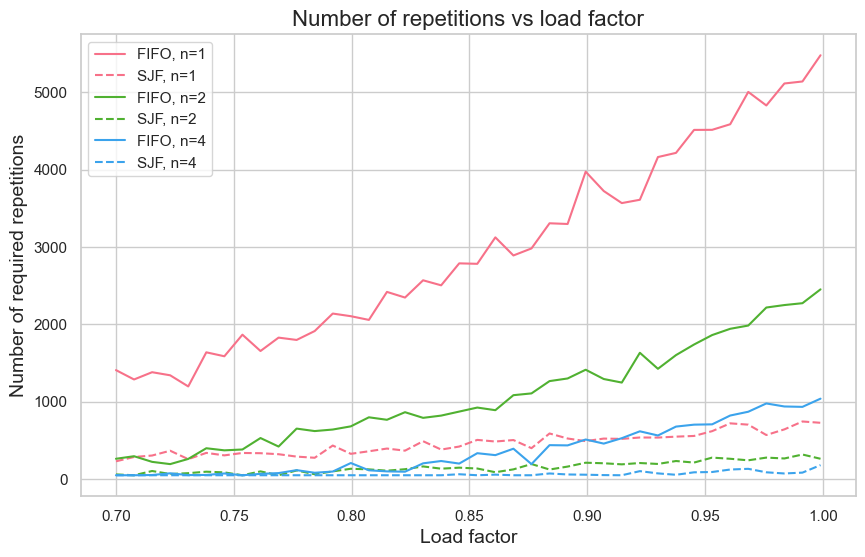

In [ ]:
# Number of measurements vs load factor
RANDOM_SEED = 42
SIMULATION_TIME = 500

MU = 1/12 # Service rate

# We repeat until the average waiting time estimate is within 3 second of the true value (95% confidence)
alpha = 0.05
CI_radius = 1
z = norm.ppf(1-alpha/2) # 1.96 for 95% confidence

decimals = 4 # Number of decimals in results

random.seed(RANDOM_SEED)

results = pd.DataFrame(columns=['priority', 'n', 'load', 'avg_customers_served', 'avg_waiting_time', 'repetitions'])

for priority in ['FIFO', 'SJF']:
    for n in [1, 2, 4]:
        for LOAD in np.linspace(0.7, 0.999, 40):
            avg_customers_served = []
            avg_waiting_times = []
            
            while True:
                LAMBDA = MU * LOAD * n

                env = simpy.Environment()
                bank = Bank(env, n, MU, priority=priority)

                env.process(setup(env, bank, SIMULATION_TIME, LAMBDA))
                env.run()

                avg_customers_served.append(bank.customers_served)
                avg_waiting_times.append(sum(bank.waiting_times)/len(bank.waiting_times))

                # Only start checking after 100 repetitions
                if len(avg_waiting_times) < 50:
                    continue

                # Check if the 1-alpha % confidence interval is within CI_radius seconds of the true value
                S = np.std(avg_waiting_times, ddof=1)

                if z * S/np.sqrt(len(avg_waiting_times)) < CI_radius:
                    break
            
            results.loc[len(results) - 1] = {
                'priority': priority,
                'n': n,
                'load': LOAD,
                'avg_customers_served': np.mean(avg_customers_served),
                'avg_waiting_time': np.mean(avg_waiting_times),
                'repetitions': len(avg_waiting_times)
            }

# Define color palette and line styles
palette = sns.color_palette("husl", n_colors=3)  # One color for each value of 'n'
line_styles = {"FIFO": "-", "SJF": "--"}  # Solid line for FIFO, dashed line for SJF

# Plot results
plt.figure(figsize=(10, 6))
for i, n in enumerate([1, 2, 4]):
    # Select data for FIFO and SJF with the current value of 'n'
    fifo_data = results[(results['priority'] == "FIFO") & (results['n'] == n)]
    sjf_data = results[(results['priority'] == "SJF") & (results['n'] == n)]
    
    # Plot FIFO with solid line
    plt.plot(fifo_data['load'], fifo_data['repetitions'], label=f"FIFO, n={n}", 
             color=palette[i], linestyle=line_styles["FIFO"])
    
    # Plot SJF with dashed line
    plt.plot(sjf_data['load'], sjf_data['repetitions'], label=f"SJF, n={n}", 
             color=palette[i], linestyle=line_styles["SJF"])

plt.title("Number of repetitions vs load factor", fontsize=16)
plt.xlabel("Load factor", fontsize=14)
plt.ylabel("Number of required repetitions", fontsize=14)
plt.grid(True)
plt.legend()
plt.show()

## Q4